### Import standard libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from textblob import Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import glob
import config
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load the data 

In [2]:
df = pd.read_csv('IMDB Dataset.csv', sep=',',skiprows=1, names=['review', 'sentiment'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
#sentiment count
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

### Clean the data

In [5]:
#Dropping the duplicates
df = df.drop_duplicates()
#Dataframe dimensions
df.shape

(49582, 2)

### Text normalization

In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

### Removing html strips and noise text

In [7]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

### Removing special characters

In [8]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

### Text stemming

In [9]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

### Removing stopwords

In [10]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'to', 'here', 'had', 'hadn', "hasn't", 'same', 'than', 'until', 'too', 'her', "couldn't", 'which', 'not', 'i', 'before', 'their', 'him', 'weren', 'shouldn', 'through', 'no', "you're", 'other', 'll', 'needn', 'at', 'his', 'whom', 'your', 'each', 'nor', 'they', 'have', 'above', 'its', 'itself', 'just', 've', "you'd", 'wasn', "it's", "wouldn't", 'you', 'some', 'it', 'against', 'myself', 'more', 'isn', 'won', 'over', 'the', 's', 'that', "you'll", 'having', 'out', 'what', 'o', 'these', 't', 'a', 'mightn', 'of', 'don', "shouldn't", 'such', "she's", 'own', "weren't", 'or', 'by', "mustn't", 'between', 'himself', 'now', 'hasn', 'should', "haven't", 'wouldn', 'once', 'ourselves', 'were', 'has', 'during', 'in', 'm', 'both', 'will', 'couldn', 'because', "wasn't", "should've", 'off', 'up', 'ain', 'aren', 'very', 'after', "mightn't", "that'll", 'how', 'do', "you've", "needn't", 'haven', 'down', 'ma', 'most', 'who', 'into', 'hers', 'does', 'when', 'shan', 'while', 'as', 'mustn', "shan't", 'so', 'he'

In [11]:
#quick check on data
df.head(5)

,review,sentiment
0,one review ha mention watch 1 Oz episod youll ...,positive
1,wonder littl product film techniqu veri unassu...,positive
2,thought thi wa wonder way spend time hot summe...,positive
3,basic famili littl boy jake think zombi hi clo...,negative
4,petter mattei love time money visual stun film...,positive


### Word Cloud

<function matplotlib.pyplot.show(close=None, block=None)>

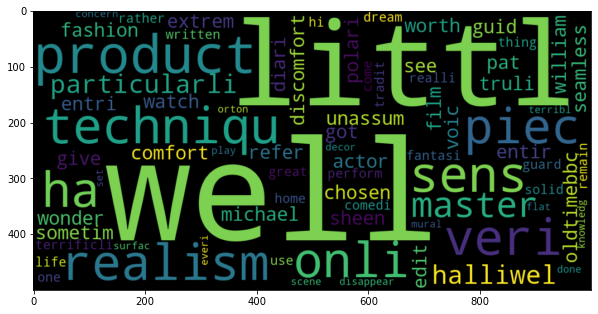

In [12]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=df.review[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

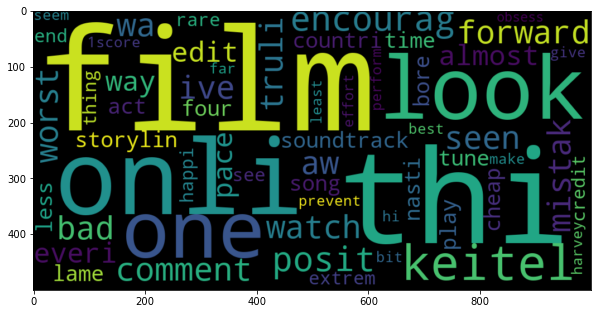

In [13]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=df.review[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Sentiment Analysis with VADER

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.

In [14]:
analyser = SentimentIntensityAnalyzer()

In [15]:
def vader_sentiment(text):
    score = analyser.polarity_scores(text)
    if score['compound'] > 0:
        result = 1
    else:
        result = 0
    return result

In [16]:
def text_blob(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0:
        result = 1
    else:
        result = 0
    return result

In [17]:
col = ['vader_sent','textblob_sent']
def pd_score(df,col,target):
    score = []
    for items in col:
        rate = accuracy_score(target, df[items])
        score.append(rate)
    scores = pd.Series(score, index=['VADER', 'TextBlob'])
    return scores

In [18]:
df['vader_sent'] = df['review'].apply(vader_sentiment)
df['textblob_sent'] = df['review'].apply(text_blob)

In [19]:
df['sentiment'] = df['sentiment'].replace(['positive'],1)

In [20]:
df['sentiment'] = df['sentiment'].replace(['negative'],0)

In [21]:
scores = pd_score(df,col,df['sentiment'])

In [22]:
rate = accuracy_score(df['sentiment'], df['afn_sent'])


KeyError: 'afn_sent'

In [ ]:
rate

In [ ]:
rate = accuracy_score(df['sentiment'], df['vader_sent'])


In [ ]:
rate


In [ ]:
rate = accuracy_score(df['sentiment'], df['textblob_sent'])


In [ ]:
rate

In [ ]:
df.head(5)

In [ ]:
score = TextBlob(df['review'][1]).sentiment.polarity


In [ ]:
score

In [ ]:
score = analyser.polarity_scores(df['review'][1])

In [ ]:
score

In [ ]:
print(scores)


In [ ]:
confusion_matrix(df['sentiment'], df['vader_sent'])


In [ ]:
confusion_matrix(df['sentiment'], df['textblob_sent'])


In [ ]:
print(classification_report(df['sentiment'], df['vader_sent']))


In [ ]:
print(classification_report(df['sentiment'], df['textblob_sent']))


In [ ]:
col_name = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']

In [ ]:
def matrix_and_array(col1, col2):
    create_matrix = confusion_matrix(col1, col2)
    create_vector = np.asarray(create_matrix).reshape(-1)
    return list(create_vector)

In [ ]:
vadar_vector =  matrix_and_array(df['sentiment'], df['vader_sent'])
textblob_vector =  matrix_and_array(df['sentiment'], df['textblob_sent'])
data = [vadar_vector, textblob_vector]
index = ['VADER', 'TextBlob']
truth = pd.DataFrame(data, columns = col_name, index = index)

In [ ]:
truth

In [ ]:

#for every row, take the tP and divide it by the tp and the fp
# for every row , take the tp and divide it by the tp and fn
precision = []
recall = []
accuracy = []
for index ,TN, FP, FN, TP in truth.itertuples():
    p = TP/(TP + FP)
    r = TP/(TP+FN)
    a = (TP + TN)/(TN + FP + FN +TP)
    precision.append(round(p,2))
    recall.append(round(r,2))
    accuracy.append(round(a,2))

In [ ]:
data = [accuracy, precision, recall]
evaluate = pd.DataFrame(data, columns = ['VADER', 'TextBlob'] , index = ['Accuracy_Score', 'Precision', 'Recall']).T.sort_values('Accuracy_Score', ascending= False)
evaluate